In [1]:
import secrets
import pandas as pd
import numpy as np
#import seaborn as sns

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

from abc import ABC, abstractmethod
from dataclasses import dataclass

#sns.set(style="whitegrid")

In [2]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [3]:
import model.basic_model as basic_model
from model.stochastic_processes import (
    create_stochastic_process,
    plot_price,
)
from model.parts.init_stake import fetch_stake_data
from model.agents import (
    CEXAgent, LSTAgent, LRTAgent, SoloAgent, StakingPoolAgent, ETFAgent,
    StandardDeposit, StandardFullWithdraw
)
import model.agents_decision as agents_decision
import model.infra_costs as infra_costs
import model.APY as APY

from config import TIMESTEPS

/Users/amber/Desktop/Simulation/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# types
Run = int
Timestep = TIMESTEPS

# Price Traj Generation

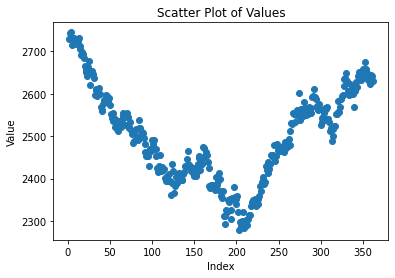

2278.6599203135465


In [5]:
eth_price_samples = create_stochastic_process(timesteps=Timestep,price_traj_type = 'concave')
eth_price_samples = [i for i in eth_price_samples] # ETH-USD pair
plot_price(eth_price_samples) 
print(min(eth_price_samples))

# Setup

In [6]:
constants = {
}

In [7]:
recent_staked = fetch_stake_data()
curr_stake_LRT = recent_staked[recent_staked['entity_category']=='Liquid Restaking']['amount_staked']
curr_stake_LST = recent_staked[recent_staked['entity_category']=='Liquid Staking']['amount_staked']
curr_stake_CEX = recent_staked[recent_staked['entity_category']=='CEXs']['amount_staked']
curr_stake_Solo = recent_staked[recent_staked['entity_category']=='Solo Stakers']['amount_staked']
curr_stake_SP = recent_staked[recent_staked['entity_category']=='Staking Pools']['amount_staked']
curr_stake_Unidentified = recent_staked[recent_staked['entity_category']=='Unidentified']['amount_staked']

In [8]:
recent_staked

,entity_category,amount_staked
0,CEXs,8.428639e+06
1,Liquid Restaking,2.831248e+06
2,Liquid Staking,1.106258e+07
3,Solo Stakers,3.402329e+05
4,Staking Pools,5.903047e+06
5,Unidentified,6.280785e+06


In [9]:
# Initialize an agent
cex_agent = CEXAgent(
    balance=curr_stake_CEX, 
    cnt=int(curr_stake_CEX/32), 
    category="CEX", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lst_agent = LSTAgent(
    balance=curr_stake_LST, 
    cnt=int(curr_stake_LST/32), 
    category="LST", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

lrt_agent = LRTAgent(
    balance=curr_stake_LRT, 
    cnt=int(curr_stake_LRT/32), 
    category="LRT", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

solo_agent = SoloAgent(
    balance=curr_stake_Solo, 
    cnt=int(curr_stake_Solo/32), 
    category="Solo", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

sp_agent = StakingPoolAgent(
    balance=curr_stake_SP, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

etf_agent = ETFAgent(
    balance=0, 
    cnt=int(curr_stake_SP/32), 
    category="SP", 
    cost_APY= 0.0,
    # full_withdrawl=0.0, 
    # partial_withdrawl=0.0, 
    deposit_behavior=StandardDeposit(), 
    withdraw_behavior=StandardFullWithdraw(),
    entity="None"
)

<ipython-input-9-f3800099faa3>:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_CEX/32),
<ipython-input-9-f3800099faa3>:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_LST/32),
<ipython-input-9-f3800099faa3>:28: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_LRT/32),
<ipython-input-9-f3800099faa3>:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(curr_stake_Solo/32),
<ipython-input-9-f3800099faa3>:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt=int(

# Simulation

In [10]:
ETH_initial_price = eth_price_samples[0]
agents = {
        "CEXAgent": cex_agent,
        "LSTAgent": lst_agent,
        "LRTAgent": lrt_agent,
        "SoloAgent": solo_agent,
        "StakingPoolAgent": sp_agent,
    }

In [11]:
@dataclass
class MVIParams:

    eth_price_process:  List[Callable[[Run, Timestep], float]] = default(
        [lambda run, timestep: eth_price_samples[timestep]]
    )

    opportunity_cost: List[float] = default([0.02])

    revenue_baseline_reduction: List[float] = default([0.005])
    mev_and_priority_add: List[float] = default([0.005])
    revenue_adjustment_beta: List[float] = default([1.0])

parameters = MVIParams().__dict__

In [12]:
psub = [{
    "policies": {
    },
    "variables": {
        "timestep": basic_model.update_timestep,
        "price": basic_model.update_price,
    }
},  { 
    "policies": {
        "action": agents_decision.deposit_withdraw
    },
    "variables": {
        "CEXAgent": agents_decision.update_CEXAgent_deposit_withdraw,
        "LSTAgent": agents_decision.update_LSTAgent_deposit_withdraw,
        "LRTAgent": agents_decision.update_LRTAgent_deposit_withdraw,
        "SoloAgent": agents_decision.update_SoloAgent_deposit_withdraw,
        "StakingPoolAgent": agents_decision.update_StakingPoolAgent_deposit_withdraw,
    }
},  { # TODO: double check the infra costs
    "policies": { 
        "action": infra_costs.calc_costs
    },
    "variables": {
        "CEXAgent": infra_costs.update_CEXAgent_cost,
        "LSTAgent": infra_costs.update_LSTAgent_cost,
        "LRTAgent": infra_costs.update_LRTAgent_cost,
        "SoloAgent": infra_costs.update_SoloAgent_cost,
        "StakingPoolAgent": infra_costs.update_StakingPoolAgent_cost,
    }
},  { 
    "policies": {
        "action": APY.calc_decentralization_and_total_staked
    },
    "variables": {
        "total_staked": APY.update_total_staked,
        "total_validator_cnt": APY.update_total_validator_cnt,
        "decentralization_metrics": APY.update_decentralization_metrics,
    }
}, { 
    "policies": {
        "action": APY.calc_issuance_APR
    },
    "variables": {
        "issuance_APR": APY.update_issuance_APR
    }
}, { 
    "policies": {
        "action": APY.calc_revenue_APY
    },
    "variables": {
        "revenue_APY": APY.update_revenue_APY,
        "revenue_APY_at_agent": APY.update_revenue_APY_at_agent
    }
}
]

initial_conditions = {
    "timestep": 0,
    "price": ETH_initial_price, 
    "CEXAgent": cex_agent,
    "LSTAgent": lst_agent,
    "LRTAgent": lrt_agent,
    "SoloAgent": solo_agent,
    "StakingPoolAgent": sp_agent,
    "ETFAgent": etf_agent,
    "total_staked": 0,
    "total_validator_cnt": 0,
    "decentralization_metrics": {},
    "issuance_APR": 0.0,
    "revenue_APY": 0.0,
    "revenue_APY_at_agent": {
        "CEXAgent": 0.0,
        "LSTAgent": 0.0,
        "LRTAgent": 0.0,
        "SoloAgent": 0.0,
        "StakingPoolAgent": 0.0
        }
}


params = parameters

model = Model(
        initial_state=initial_conditions,
        state_update_blocks=psub,
        params=params,
    )

In [14]:
num_simulations = 1000  
all_results = []  

for i in range(num_simulations):
    eth_price_samples = create_stochastic_process(timesteps=Timestep, price_traj_type='concave')
    eth_price_samples = [i for i in eth_price_samples]  
    
    params = parameters

    model = Model(
            initial_state=initial_conditions,
            state_update_blocks=psub,
            params=params,
        )
    
    
    simulation = Simulation(model=model, timesteps=Timestep, runs=1)

    simulation.model.params.update({
            "eth_price_process" : [lambda run, timestep: eth_price_samples[timestep]]
        })
    experiment = Experiment([simulation])
    experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
    
    # 运行实验并将结果保存到 all_results 列表
    results = experiment.run()
    df = pd.DataFrame(results)
    df['simulation_run'] = i  # 添加列来标识每次仿真运行
    all_results.append(df)

# 将所有模拟的结果合并到一个 DataFrame 中
final_results = pd.concat(all_results, ignore_index=True)

2024-10-29 17:58:52,082 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:58:53,223 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:58:54,143 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:58:55,204 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:58:56,094 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:58:56,978 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:58:57,849 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:58:58,913 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:58:59,794 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:59:00,670 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:59:01,599 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:59:02,700 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:59:03,588 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 17:59:04,466 I

In [15]:
num_simulations = 1000  
all_results = []  

for i in range(num_simulations):
    eth_price_samples = create_stochastic_process(timesteps=Timestep, price_traj_type='convex')
    eth_price_samples = [i for i in eth_price_samples]  
    
    params = parameters

    model = Model(
            initial_state=initial_conditions,
            state_update_blocks=psub,
            params=params,
        )
    
    
    simulation = Simulation(model=model, timesteps=Timestep, runs=1)

    simulation.model.params.update({
            "eth_price_process" : [lambda run, timestep: eth_price_samples[timestep]]
        })
    experiment = Experiment([simulation])
    experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
    
    # 运行实验并将结果保存到 all_results 列表
    results = experiment.run()
    df = pd.DataFrame(results)
    df['simulation_run'] = i  # 添加列来标识每次仿真运行
    all_results.append(df)

# 将所有模拟的结果合并到一个 DataFrame 中
final_results_convex = pd.concat(all_results, ignore_index=True)

2024-10-29 18:17:18,855 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:20,132 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:21,084 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:22,019 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:23,241 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:24,236 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:25,270 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:26,404 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:27,344 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:28,292 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:29,227 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:30,165 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:31,137 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:32,074 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:33,048 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:34,225 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:35,180 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:36,157 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:37,363 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:38,299 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:39,239 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:40,182 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:41,117 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:42,087 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:43,021 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:43,952 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:44,899 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:46,226 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:47,159 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:48,230 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:49,272 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:50,200 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:51,136 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:52,083 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:53,047 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:53,982 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:54,914 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:55,840 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:56,997 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:57,958 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:17:58,972 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:00,024 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:00,962 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:01,894 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:02,864 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:03,795 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:04,863 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:05,819 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:06,889 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:08,120 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:09,052 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:10,034 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:11,117 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:12,049 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:13,044 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:14,066 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:14,997 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:15,929 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:16,867 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:17,821 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:18,996 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:19,971 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:20,905 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:22,086 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:23,014 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:23,957 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:24,884 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:25,888 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:26,842 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:27,801 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:28,732 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:29,674 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:30,981 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:31,908 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:32,942 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:33,941 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:34,922 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:35,858 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:36,843 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:37,771 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:38,700 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:39,655 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:40,588 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:41,735 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:42,669 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:43,643 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:44,856 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:45,783 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:46,716 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:47,660 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:48,592 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:49,552 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:50,475 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:51,404 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:52,600 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:53,527 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:54,514 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:55,613 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:18:56,558 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:05,314 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:06,352 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:07,355 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:08,424 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:09,552 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:11,011 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:12,146 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:13,523 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:14,954 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:15,904 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:16,863 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:17,825 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:18,769 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:19,747 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:20,692 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:21,730 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:22,996 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:23,962 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:25,241 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:26,208 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:27,171 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:28,125 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:29,087 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:30,072 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:31,072 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:32,040 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:33,248 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:34,211 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:35,145 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:36,245 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:37,206 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:38,183 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:39,151 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:40,085 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:41,055 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:41,988 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:42,920 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:43,853 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:45,093 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:46,154 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:47,390 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:48,366 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:49,312 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:50,242 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:51,220 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:52,157 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:53,096 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:54,027 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:54,961 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:56,140 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:57,080 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:58,100 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:20:59,173 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:00,114 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:01,079 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:02,008 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:02,941 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:03,871 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:04,807 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:05,766 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:06,959 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:07,902 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:08,879 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:10,144 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:11,074 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:12,016 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:12,953 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:14,065 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:15,041 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:15,974 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:16,906 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:18,049 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:19,036 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:20,007 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:21,156 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:22,090 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:23,031 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:24,004 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:24,939 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:25,872 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:26,887 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:27,847 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:28,812 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:30,041 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:30,990 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:32,011 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:33,003 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:33,976 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:34,938 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:35,873 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:36,805 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:37,773 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:38,731 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:39,664 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:40,830 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:41,785 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:42,803 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:43,915 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:44,851 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:45,787 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:46,722 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:47,685 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:48,628 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:49,560 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:50,492 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:51,699 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:52,643 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:53,594 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:54,684 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:55,658 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:56,646 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:57,582 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:58,507 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:21:59,435 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:00,362 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:01,324 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:02,277 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:03,480 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:04,417 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:05,438 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:06,461 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:07,443 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:08,486 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:09,457 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:10,461 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:11,414 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:12,371 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:13,304 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:14,608 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:15,593 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:16,590 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:17,875 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:18,808 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:19,748 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:20,685 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:21,615 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:22,574 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:23,517 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:24,455 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:25,721 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:26,666 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:27,804 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:28,839 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:29,869 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:30,859 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:31,859 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:32,815 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:33,763 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:34,702 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:35,639 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:36,870 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:37,812 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:39,009 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:40,038 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:40,981 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:41,911 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:42,839 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:43,772 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:44,702 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:45,633 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:46,559 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:47,778 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:48,869 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:49,796 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:50,909 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:51,844 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:52,775 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:53,705 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:54,632 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:55,560 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:56,556 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:57,484 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:58,413 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:22:59,532 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:00,463 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:01,432 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:02,435 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:03,359 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:04,281 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:05,206 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:06,128 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:07,052 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:08,012 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:08,954 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:10,046 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:10,975 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:11,902 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:12,904 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:14,011 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:14,935 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:15,873 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:16,801 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:17,725 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:18,651 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:19,576 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:20,502 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:21,654 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:22,581 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:23,548 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:24,535 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:25,502 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:26,426 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:27,400 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:28,327 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:29,250 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:30,173 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:31,103 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:32,023 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:33,115 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:34,040 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:35,013 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:35,999 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:36,968 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:37,891 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:38,838 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:39,764 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:40,686 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:41,609 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:42,533 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:43,624 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:44,559 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:45,484 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:46,508 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:47,463 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:48,388 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:49,312 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:50,236 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:51,160 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:52,086 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:53,011 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:53,938 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:55,062 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:55,986 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:56,914 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:57,972 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:58,898 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:23:59,823 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:00,750 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:01,680 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:02,608 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:03,529 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:04,454 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:05,380 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:06,462 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:07,438 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:08,415 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:09,448 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:10,375 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:11,300 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:12,221 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:13,140 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:24:14,221 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:08,322 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:09,657 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:10,780 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:12,155 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:13,257 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:14,673 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:15,747 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:16,867 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:17,808 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:18,749 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:19,717 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:20,927 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:21,875 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:22,903 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:23,836 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:24,860 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:25,804 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:26,738 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:27,678 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:28,619 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:29,553 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:30,495 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:31,696 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:32,647 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:33,631 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:34,633 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:35,585 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:36,559 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:37,521 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:38,499 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:39,425 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:40,353 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:41,306 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:42,402 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:43,332 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:44,260 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:45,237 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:46,278 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:47,207 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:48,133 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:49,059 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:49,983 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:50,910 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:51,875 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:52,800 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:53,892 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:54,817 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:55,743 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:56,772 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:57,705 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:58,631 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:29:59,557 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:00,484 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:01,416 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:02,341 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:03,270 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:04,195 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:05,350 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:06,278 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:07,238 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:08,224 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:09,152 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:10,077 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:11,024 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:11,960 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:12,886 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:13,944 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:14,918 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:16,162 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:17,142 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:18,107 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:19,252 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:20,179 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:21,105 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:22,031 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:22,992 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:23,914 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:24,839 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:25,762 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:26,689 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:27,768 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:28,694 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:29,753 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:30,766 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:31,696 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:32,620 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:33,553 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:34,479 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:35,422 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:36,460 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:37,433 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:38,582 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:39,533 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:40,462 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:41,572 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:42,500 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:43,423 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:44,352 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:45,282 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:46,206 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:47,137 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:48,102 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:49,030 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:50,098 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:51,026 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:51,956 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:53,031 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:53,963 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:54,886 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:55,815 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:56,747 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:57,672 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:58,600 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:30:59,527 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:00,456 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:01,534 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:02,463 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:03,441 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:04,427 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:05,351 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:06,279 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:07,204 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:08,128 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:09,053 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:10,014 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:10,938 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:11,880 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:31:12,939 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>
<class 'float'>


2024-10-29 18:31:13,974 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:14,964 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:15,941 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:16,866 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:17,794 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:18,720 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:19,647 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:20,573 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:21,497 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:22,423 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:23,529 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:24,455 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:25,384 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:26,430 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:27,392 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:28,317 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:29,241 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:30,165 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:31,090 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:32,016 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:32,941 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:33,868 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:34,975 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:35,901 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:36,828 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:37,874 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:38,811 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:39,737 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:40,662 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:41,612 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:42,534 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:43,457 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:44,382 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:45,338 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:46,450 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:47,376 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:48,334 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:49,347 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:50,272 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:51,197 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:52,125 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:53,050 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:53,977 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:54,903 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:55,830 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:56,757 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:57,845 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:58,774 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:31:59,756 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:00,769 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:01,742 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:02,668 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:03,598 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:04,566 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:05,495 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:06,424 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:07,353 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:08,458 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:09,396 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:10,324 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:11,375 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:12,330 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:13,258 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:14,304 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:15,241 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:16,172 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:17,143 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:18,069 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:18,997 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:20,182 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:21,122 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:22,092 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:23,102 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:24,042 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:24,974 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:25,954 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:26,881 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:27,814 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:28,745 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:29,676 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:30,790 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:31,722 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:32,656 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:33,907 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:34,834 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:35,760 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:36,690 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:37,627 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:38,552 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:39,477 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:40,399 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:41,322 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:42,453 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:43,374 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:44,297 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:45,315 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:46,260 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:47,185 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:48,109 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:49,033 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:49,956 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:50,917 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:51,839 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:52,760 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:53,876 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:54,856 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:55,840 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:56,862 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:57,788 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:58,714 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:32:59,641 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:00,566 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:01,490 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:02,415 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:03,340 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:04,415 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:05,347 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:06,274 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:07,254 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:08,292 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:09,218 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:10,141 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:11,064 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:11,998 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:12,930 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:13,959 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:14,887 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:16,028 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:16,952 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:17,881 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:18,907 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:19,827 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:20,747 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:21,669 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:22,590 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:23,543 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:24,468 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:25,391 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:26,316 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:27,393 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:28,318 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:29,282 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:30,389 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:31,316 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:32,239 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:33,160 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:34,087 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:35,053 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:35,974 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:36,897 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:37,987 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:39,073 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:40,085 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:41,149 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:42,075 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:43,022 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:43,949 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:44,871 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:45,796 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:46,720 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:47,645 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:48,571 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:49,669 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:50,592 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:51,516 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:52,532 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:53,483 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:54,408 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:55,334 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:56,260 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:57,187 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:58,111 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:59,036 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:33:59,962 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:34:01,030 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:34:01,957 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:34:02,921 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:34:03,940 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:34:04,863 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:34:05,785 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:28,632 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:29,624 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:30,558 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:31,494 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:32,452 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:33,851 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:34,948 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:36,149 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:37,425 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:38,517 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:39,545 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:40,498 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:41,433 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:42,372 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:43,308 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:44,254 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:45,562 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:46,552 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:47,589 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:48,558 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:49,496 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:50,429 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:51,364 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:52,303 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:53,279 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:54,227 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:55,159 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:56,267 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:57,215 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:58,151 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:40:59,245 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:00,188 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:01,140 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:02,124 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:03,135 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:04,128 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:05,091 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:06,040 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:07,231 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:08,166 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:09,104 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:10,120 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:11,096 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:12,021 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:12,946 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:14,032 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:14,960 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:15,891 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:16,814 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:17,737 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:18,831 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:19,757 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:20,681 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:21,736 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:22,705 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:23,628 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:24,554 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:25,474 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:26,403 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:27,327 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:28,250 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:29,174 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:30,266 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:31,191 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:32,149 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:33,146 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:34,073 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:34,996 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:35,919 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:36,844 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:37,772 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:38,736 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:39,661 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:40,746 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:41,695 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:42,616 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:43,582 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:44,609 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:45,566 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:46,514 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:47,436 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:48,358 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:49,283 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:50,205 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:51,127 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:52,210 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:53,179 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:54,105 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:55,109 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:56,098 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:57,024 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:57,952 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:58,878 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:41:59,802 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:00,724 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:01,646 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:02,574 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:03,631 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:04,553 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:05,478 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:06,548 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:07,511 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:08,440 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:09,365 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:10,288 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:11,215 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:12,140 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:13,070 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:14,134 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:15,265 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:16,209 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:17,204 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:18,195 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:19,124 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:20,050 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:21,035 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:21,961 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:22,889 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:23,825 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:24,755 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:25,832 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:26,893 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:27,874 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:29,019 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:29,952 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:30,877 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:31,883 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:32,861 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:33,807 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:34,737 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:35,663 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:36,589 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:37,775 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:38,704 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:39,693 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:40,664 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:41,600 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:42,521 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:43,445 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:44,429 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:45,357 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:46,372 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:47,337 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:48,456 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:49,424 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:50,350 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:51,392 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:52,319 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:53,245 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:54,169 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:55,094 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:56,022 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:56,951 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:57,876 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:58,805 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:42:59,908 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:00,835 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:01,765 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:02,788 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:03,749 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:04,673 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:05,603 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:06,543 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:07,483 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:08,418 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:09,346 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:10,274 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:11,366 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:12,292 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:13,269 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:14,436 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:15,652 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:16,581 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:17,508 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:18,436 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:19,407 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:20,332 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:21,260 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:22,393 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:23,319 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:24,243 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:25,276 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:26,202 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:27,134 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:28,063 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:28,987 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:29,913 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:30,841 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:31,769 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:32,695 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:33,824 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:34,749 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:36,007 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:36,975 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:37,906 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:38,832 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:39,794 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:40,729 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:41,655 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:42,580 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:43,504 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:44,600 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:45,524 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:46,498 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:47,535 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:48,473 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:49,400 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:50,376 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:51,350 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:52,274 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:53,203 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:54,130 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:55,058 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:56,151 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:57,079 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:58,027 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:59,060 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:43:59,988 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:00,916 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:01,846 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:02,808 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:03,734 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:04,659 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:05,584 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:06,509 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:07,589 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:08,518 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:09,490 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:10,507 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:11,441 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:12,370 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:13,298 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:14,377 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:15,301 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:16,239 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:17,165 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:18,363 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:19,287 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:20,226 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:21,272 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:22,200 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:23,128 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:24,056 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:24,982 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:25,907 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:26,839 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:27,768 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:28,694 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:29,782 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:30,756 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:31,713 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:32,720 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:33,648 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:34,577 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:35,504 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:36,558 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:37,484 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:38,412 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:39,341 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:40,268 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:41,345 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:42,275 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:43,306 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:44,294 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:45,264 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:46,240 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:47,160 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:48,084 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:49,007 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:49,981 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:50,904 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:52,011 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:52,935 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:53,860 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:54,909 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:55,839 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:56,768 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:57,691 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:58,619 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:44:59,589 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:00,508 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:01,437 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:02,362 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:03,526 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:04,454 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:05,384 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:06,407 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:07,339 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:08,267 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:09,194 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:10,117 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:11,082 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:12,005 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:12,929 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:14,187 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:15,167 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:16,114 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:17,136 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:18,133 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:19,484 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:20,468 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:21,395 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:22,319 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:23,243 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:24,166 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:25,091 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:26,281 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:27,211 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:28,232 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:29,228 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:30,150 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:31,074 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:31,999 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:33,001 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:33,928 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:34,854 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:35,778 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:36,849 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:37,780 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:38,707 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:39,734 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:40,727 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:41,660 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:42,583 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:43,505 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:44,435 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:45,360 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:46,303 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:47,228 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:48,311 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:49,240 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:50,166 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:51,196 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:52,125 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:53,048 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:53,973 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:54,936 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:55,862 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:56,786 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:57,713 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


2024-10-29 18:45:58,639 INFO root Starting simulation 0 / run 0 / subset 0


<class 'float'>


In [16]:
num_simulations = 1000  
all_results = []  

for i in range(num_simulations):
    eth_price_samples = create_stochastic_process(timesteps=Timestep, price_traj_type='none')
    eth_price_samples = [i for i in eth_price_samples]  
    
    params = parameters

    model = Model(
            initial_state=initial_conditions,
            state_update_blocks=psub,
            params=params,
        )
    
    
    simulation = Simulation(model=model, timesteps=Timestep, runs=1)

    simulation.model.params.update({
            "eth_price_process" : [lambda run, timestep: eth_price_samples[timestep]]
        })
    experiment = Experiment([simulation])
    experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
    
    # 运行实验并将结果保存到 all_results 列表
    results = experiment.run()
    df = pd.DataFrame(results)
    df['simulation_run'] = i  # 添加列来标识每次仿真运行
    all_results.append(df)

# 将所有模拟的结果合并到一个 DataFrame 中
final_results_none = pd.concat(all_results, ignore_index=True)

2024-10-29 18:46:43,067 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:44,648 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:45,579 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:46,563 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:47,631 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:48,554 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:49,481 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:50,409 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:51,397 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:52,335 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:53,262 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:54,180 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:55,106 INFO root Starting simulation 0 / run 0 / subset 0
2024-10-29 18:46:56,332 I

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
agent_names = [
        "CEXAgent",
        "LSTAgent",
        "LRTAgent",
        "SoloAgent",
        "StakingPoolAgent",
    ]

In [26]:
len(final_results)

360000

    timestep  CEXAgent_revenue_APY  LSTAgent_revenue_APY  \
6          1              0.019327              0.023879   
12         2              0.019323              0.023874   
18         3              0.019318              0.023868   
24         4              0.019314              0.023863   
30         5              0.019310              0.023858   

    LRTAgent_revenue_APY  SoloAgent_revenue_APY  StakingPoolAgent_revenue_APY  
6               0.021732               0.020966                      0.021578  
12              0.021727               0.021007                      0.021639  
18              0.021723               0.021089                      0.021758  
24              0.021718               0.021041                      0.021693  
30              0.021713               0.021081                      0.021753  


In [43]:
def revenue_APY_summary(final_results):
    apy_df = pd.DataFrame({
        "timestep": final_results["timestep"]
    })

    for agent in agent_names:
        apy_df[agent + '_revenue_APY'] = final_results["revenue_APY_at_agent"].apply(lambda x: x.get(agent, None) if isinstance(x, dict) else None)

    print(apy_df.head())

    revenue_summary = apy_df.groupby("timestep").agg({agent + '_revenue_APY': ['mean', 'std'] for agent in agent_names})

    revenue_quantiles = apy_df.groupby("timestep").apply(
        lambda x: x[[agent + '_revenue_APY' for agent in agent_names]].quantile([0.25, 0.5, 0.75])
    )

    revenue_quantiles = revenue_quantiles.reset_index().pivot_table(
        index="timestep",
        columns=["level_1"],
        values=[agent + '_revenue_APY' for agent in agent_names]
    )

    revenue_quantiles.columns.names = ["Agent", "Quantile"]
    print(revenue_summary.head())
    print(revenue_quantiles.head())

    return revenue_summary, revenue_quantiles

In [65]:
def plot_revenue_APY_summary(revenue_summary, revenue_quantiles, title):
    plt.figure(figsize=(12, 8))

    for agent in agent_names:
        mean_col = (agent + '_revenue_APY', 'mean')
        std_col = (agent + '_revenue_APY', 'std')
        
        plt.plot(revenue_summary.index, revenue_summary[mean_col], label=agent)
        
        plt.fill_between(
            revenue_summary.index, 
            revenue_summary[mean_col] - revenue_summary[std_col], 
            revenue_summary[mean_col] + revenue_summary[std_col], 
            alpha=0.2
        )

    plt.xlabel("Timestep")
    plt.ylabel("Revenue APY (%)")
    plt.title("Mean and Std of Revenue APY for Each Agent Over Time - "+ title)
    plt.legend()
    plt.show()

    timestep  CEXAgent_revenue_APY  LSTAgent_revenue_APY  \
6          1              0.019327              0.023879   
12         2              0.019323              0.023874   
18         3              0.019318              0.023868   
24         4              0.019314              0.023863   
30         5              0.019310              0.023858   

    LRTAgent_revenue_APY  SoloAgent_revenue_APY  StakingPoolAgent_revenue_APY  
6               0.021732               0.020966                      0.021578  
12              0.021727               0.021007                      0.021639  
18              0.021723               0.021089                      0.021758  
24              0.021718               0.021041                      0.021693  
30              0.021713               0.021081                      0.021753  


<ipython-input-43-0e3a91a3d476>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  revenue_quantiles = apy_df.groupby("timestep").apply(


         CEXAgent_revenue_APY               LSTAgent_revenue_APY  \
                         mean           std                 mean   
timestep                                                           
1                    0.019327  0.000000e+00             0.023879   
2                    0.019323  4.570591e-10             0.023874   
3                    0.019318  9.322042e-10             0.023868   
4                    0.019314  1.456119e-09             0.023863   
5                    0.019310  1.913953e-09             0.023858   

                       LRTAgent_revenue_APY                \
                   std                 mean           std   
timestep                                                    
1         0.000000e+00             0.021732  0.000000e+00   
2         5.736843e-10             0.021727  4.948998e-10   
3         1.170051e-09             0.021723  1.009397e-09   
4         1.827622e-09             0.021718  1.576720e-09   
5         2.402226e-09      

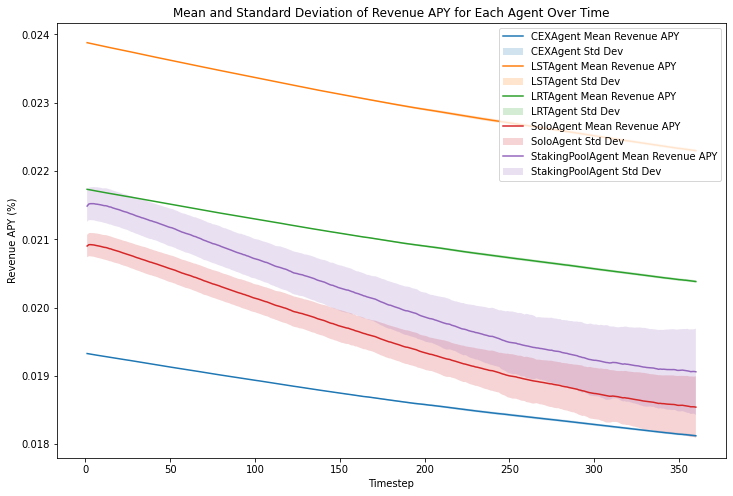

In [45]:
# Concave
final_results = final_results[final_results['substep']== final_results['substep'].max()]
revenue_summary, revenue_quantiles = revenue_APY_summary(final_results)
plot_revenue_APY_summary(revenue_summary, revenue_quantiles)

    timestep  CEXAgent_revenue_APY  LSTAgent_revenue_APY  \
6          1              0.019327              0.023879   
12         2              0.019323              0.023874   
18         3              0.019318              0.023868   
24         4              0.019314              0.023863   
30         5              0.019310              0.023858   

    LRTAgent_revenue_APY  SoloAgent_revenue_APY  StakingPoolAgent_revenue_APY  
6               0.021732               0.020966                      0.021578  
12              0.021727               0.021007                      0.021639  
18              0.021723               0.021089                      0.021758  
24              0.021718               0.021041                      0.021693  
30              0.021713               0.021081                      0.021753  
         CEXAgent_revenue_APY               LSTAgent_revenue_APY  \
                         mean           std                 mean   
timestep               

<ipython-input-43-0e3a91a3d476>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  revenue_quantiles = apy_df.groupby("timestep").apply(


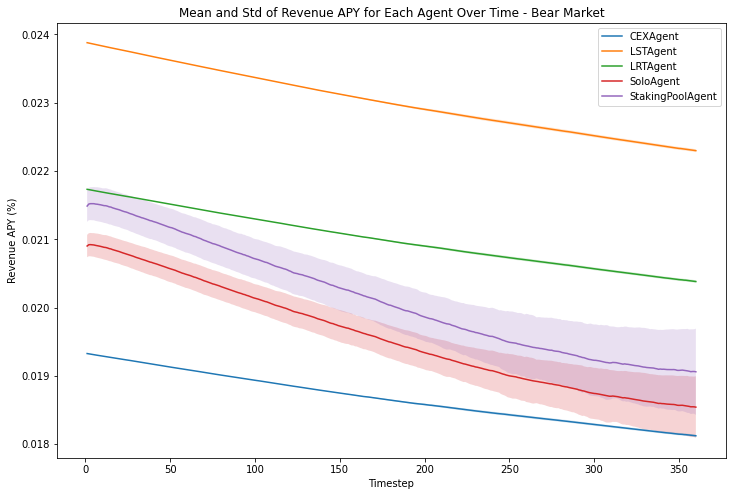

In [66]:
revenue_summary, revenue_quantiles = revenue_APY_summary(final_results)
plot_revenue_APY_summary(revenue_summary, revenue_quantiles, "Bear Market")

    timestep  CEXAgent_revenue_APY  LSTAgent_revenue_APY  \
6          1              0.019327              0.023879   
12         2              0.019323              0.023875   
18         3              0.019320              0.023870   
24         4              0.019317              0.023866   
30         5              0.019313              0.023862   

    LRTAgent_revenue_APY  SoloAgent_revenue_APY  StakingPoolAgent_revenue_APY  
6               0.021732               0.019475                      0.019478  
12              0.021728               0.019521                      0.019546  
18              0.021724               0.019542                      0.019578  
24              0.021721               0.019573                      0.019623  
30              0.021717               0.019504                      0.019528  
         CEXAgent_revenue_APY               LSTAgent_revenue_APY  \
                         mean           std                 mean   
timestep               

<ipython-input-43-0e3a91a3d476>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  revenue_quantiles = apy_df.groupby("timestep").apply(


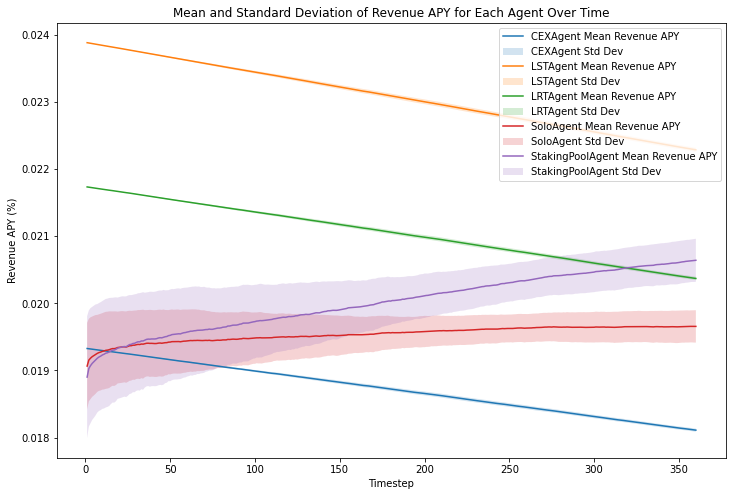

In [50]:
# Convex
final_results_convex = final_results_convex[final_results_convex['substep']== final_results_convex['substep'].max()]
revenue_summary_convex, revenue_quantiles_convex = revenue_APY_summary(final_results_convex)
plot_revenue_APY_summary(revenue_summary_convex, revenue_quantiles_convex)

    timestep  CEXAgent_revenue_APY  LSTAgent_revenue_APY  \
6          1              0.019327              0.023879   
12         2              0.019323              0.023875   
18         3              0.019320              0.023870   
24         4              0.019317              0.023866   
30         5              0.019313              0.023862   

    LRTAgent_revenue_APY  SoloAgent_revenue_APY  StakingPoolAgent_revenue_APY  
6               0.021732               0.019475                      0.019478  
12              0.021728               0.019521                      0.019546  
18              0.021724               0.019542                      0.019578  
24              0.021721               0.019573                      0.019623  
30              0.021717               0.019504                      0.019528  
         CEXAgent_revenue_APY               LSTAgent_revenue_APY  \
                         mean           std                 mean   
timestep               

<ipython-input-43-0e3a91a3d476>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  revenue_quantiles = apy_df.groupby("timestep").apply(


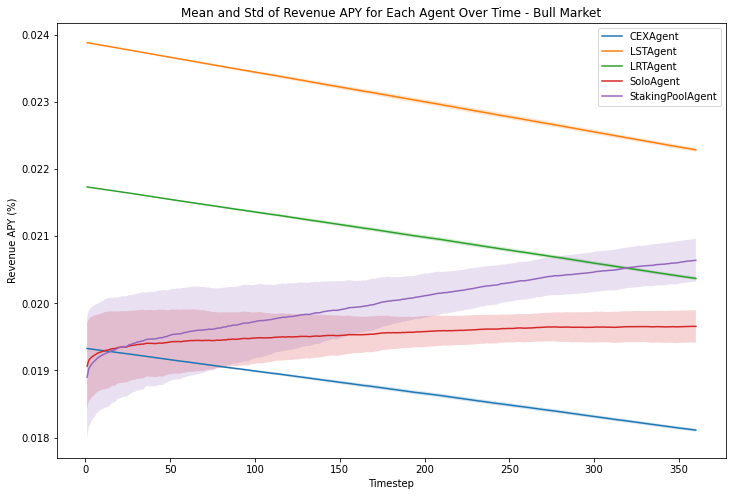

In [67]:
revenue_summary_convex, revenue_quantiles_convex = revenue_APY_summary(final_results_convex)
plot_revenue_APY_summary(revenue_summary_convex, revenue_quantiles_convex, "Bull Market")

    timestep  CEXAgent_revenue_APY  LSTAgent_revenue_APY  \
6          1              0.019327              0.023879   
12         2              0.019323              0.023875   
18         3              0.019320              0.023870   
24         4              0.019317              0.023866   
30         5              0.019313              0.023862   

    LRTAgent_revenue_APY  SoloAgent_revenue_APY  StakingPoolAgent_revenue_APY  
6               0.021732               0.019558                      0.019595  
12              0.021728               0.019774                      0.019901  
18              0.021724               0.019780                      0.019912  
24              0.021721               0.019637                      0.019713  
30              0.021717               0.019585                      0.019643  
         CEXAgent_revenue_APY               LSTAgent_revenue_APY  \
                         mean           std                 mean   
timestep               

<ipython-input-43-0e3a91a3d476>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  revenue_quantiles = apy_df.groupby("timestep").apply(


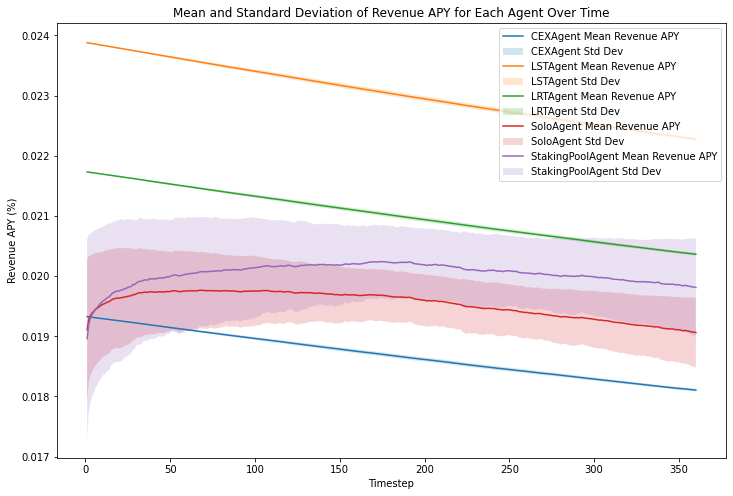

In [51]:
# None
final_results_none = final_results_none[final_results_none['substep']== final_results_none['substep'].max()]
revenue_summary_none, revenue_quantiles_none = revenue_APY_summary(final_results_none)
plot_revenue_APY_summary(revenue_summary_none, revenue_quantiles_none)

    timestep  CEXAgent_revenue_APY  LSTAgent_revenue_APY  \
6          1              0.019327              0.023879   
12         2              0.019323              0.023875   
18         3              0.019320              0.023870   
24         4              0.019317              0.023866   
30         5              0.019313              0.023862   

    LRTAgent_revenue_APY  SoloAgent_revenue_APY  StakingPoolAgent_revenue_APY  
6               0.021732               0.019558                      0.019595  
12              0.021728               0.019774                      0.019901  
18              0.021724               0.019780                      0.019912  
24              0.021721               0.019637                      0.019713  
30              0.021717               0.019585                      0.019643  


<ipython-input-43-0e3a91a3d476>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  revenue_quantiles = apy_df.groupby("timestep").apply(


         CEXAgent_revenue_APY               LSTAgent_revenue_APY  \
                         mean           std                 mean   
timestep                                                           
1                    0.019327  0.000000e+00             0.023879   
2                    0.019323  3.552298e-07             0.023875   
3                    0.019319  7.258213e-07             0.023870   
4                    0.019315  1.194394e-06             0.023865   
5                    0.019312  1.480530e-06             0.023860   

                       LRTAgent_revenue_APY                \
                   std                 mean           std   
timestep                                                    
1         0.000000e+00             0.021732  0.000000e+00   
2         4.458720e-07             0.021728  3.846393e-07   
3         9.110120e-07             0.021724  7.859222e-07   
4         1.499127e-06             0.021720  1.293312e-06   
5         1.858235e-06      

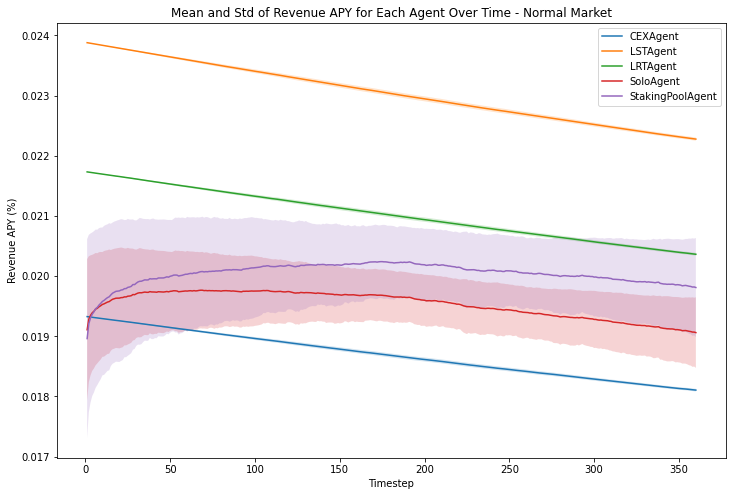

In [68]:
revenue_summary_none, revenue_quantiles_none = revenue_APY_summary(final_results_none)
plot_revenue_APY_summary(revenue_summary_none, revenue_quantiles_none, "Normal Market")

In [71]:
final_results_none.to_csv('sim-results/sim-none-1000.csv')

In [72]:
final_results_convex.to_csv('sim-results/sim-convex-1000.csv')

In [55]:
def plot_avg_revenue_apy(final_results, title = "Bear Market"):
    revenue_summary = final_results.groupby("timestep")["revenue_APY"].agg(['mean', 'std', 'min', 'max', 
                                                                            lambda x: x.quantile(0.25), 
                                                                            lambda x: x.quantile(0.5), 
                                                                            lambda x: x.quantile(0.75)])

    revenue_summary.columns = ['mean', 'std', 'min', 'max', '25th_percentile', 'median', '75th_percentile']


    plt.figure(figsize=(14, 6))
    plt.plot(revenue_summary.index, revenue_summary['mean'], label="Mean Revenue APY", color="blue")
    plt.fill_between(revenue_summary.index, 
                    revenue_summary['mean'] - revenue_summary['std'], 
                    revenue_summary['mean'] + revenue_summary['std'], 
                    color='blue', alpha=0.2, label="Std Dev")

    plt.xlabel("Timestep")
    plt.ylabel("Revenue APY")
    plt.title("Mean and Standard Deviation of Revenue APY Over Time")
    plt.legend()
    plt.show()

    # 可视化：按时间步长的 Revenue APY 分位数
    plt.figure(figsize=(14, 6))
    plt.plot(revenue_summary.index, revenue_summary['25th_percentile'], label="25th Percentile", linestyle="--", color="orange")
    plt.plot(revenue_summary.index, revenue_summary['median'], label="Median", color="green")
    plt.plot(revenue_summary.index, revenue_summary['75th_percentile'], label="75th Percentile", linestyle="--", color="red")

    plt.xlabel("Timestep")
    plt.ylabel("Revenue APY")
    plt.title("Quantiles of Revenue APY Over Time - " + title)
    plt.legend()
    plt.show()

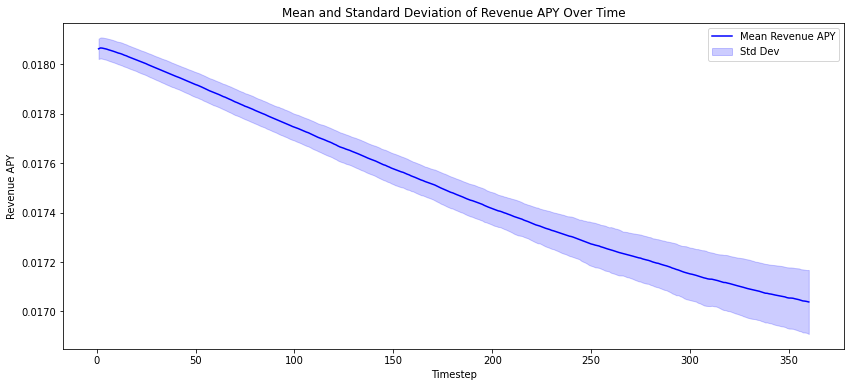

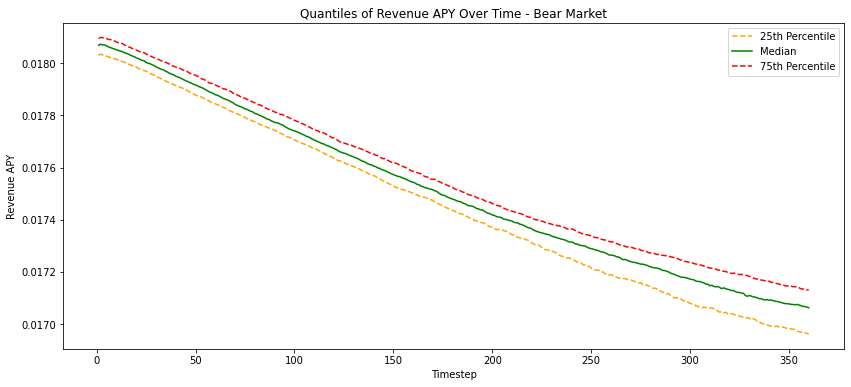

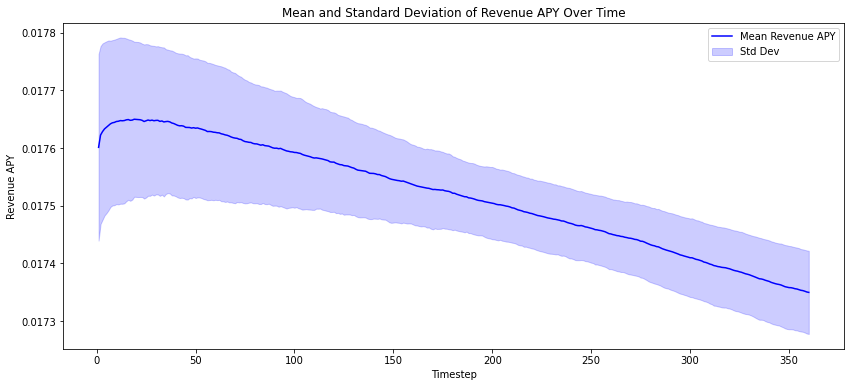

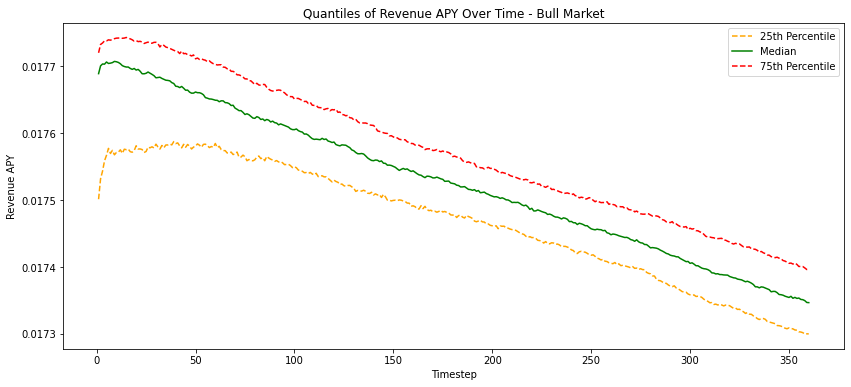

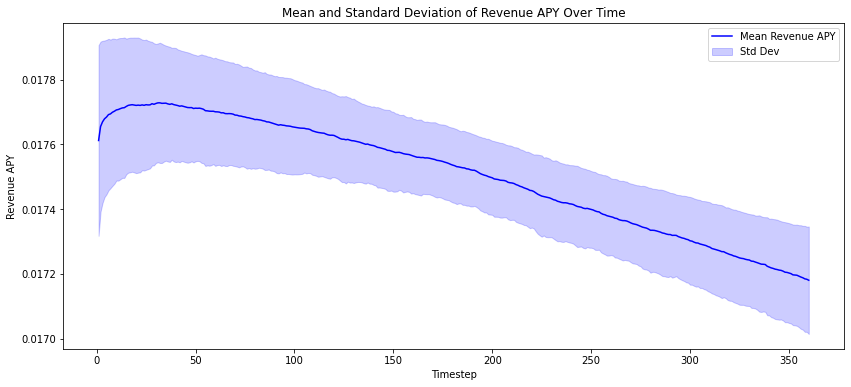

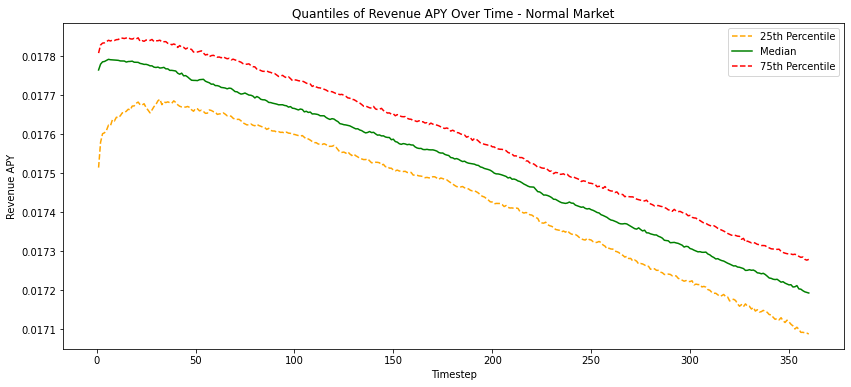

In [56]:
plot_avg_revenue_apy(final_results, title = "Bear Market")
plot_avg_revenue_apy(final_results_convex, title = "Bull Market")
plot_avg_revenue_apy(final_results_none, title = "Normal Market")

In [69]:
def plot_total_staked(final_results, title = "Bear Market"):
    revenue_summary = final_results.groupby("timestep")["total_staked"].agg(['mean', 'std', 'min', 'max', 
                                                                            lambda x: x.quantile(0.25), 
                                                                            lambda x: x.quantile(0.5), 
                                                                            lambda x: x.quantile(0.75)])

    revenue_summary.columns = ['mean', 'std', 'min', 'max', '25th_percentile', 'median', '75th_percentile']


    plt.figure(figsize=(14, 6))
    plt.plot(revenue_summary.index, revenue_summary['mean'], label="Mean Revenue APY", color="blue")
    plt.fill_between(revenue_summary.index, 
                    revenue_summary['mean'] - revenue_summary['std'], 
                    revenue_summary['mean'] + revenue_summary['std'], 
                    color='blue', alpha=0.2, label="Std Dev")

    plt.xlabel("Timestep")
    plt.ylabel("Total Staked")
    plt.title("Total Staked Over Time - "+ title)
    plt.legend()
    plt.show()

    # 可视化：按时间步长的 Revenue APY 分位数
    plt.figure(figsize=(14, 6))
    plt.plot(revenue_summary.index, revenue_summary['25th_percentile'], label="25th Percentile", linestyle="--", color="orange")
    plt.plot(revenue_summary.index, revenue_summary['median'], label="Median", color="green")
    plt.plot(revenue_summary.index, revenue_summary['75th_percentile'], label="75th Percentile", linestyle="--", color="red")

    plt.xlabel("Timestep")
    plt.ylabel("Total Staked")
    plt.title("Total Staked Over Time - " + title)
    plt.legend()
    plt.show()

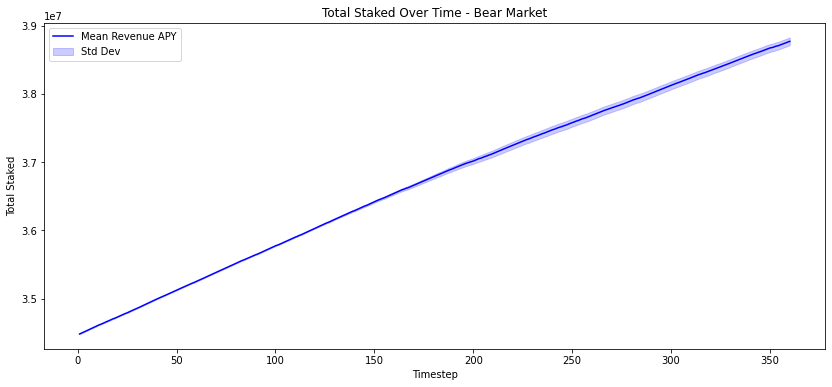

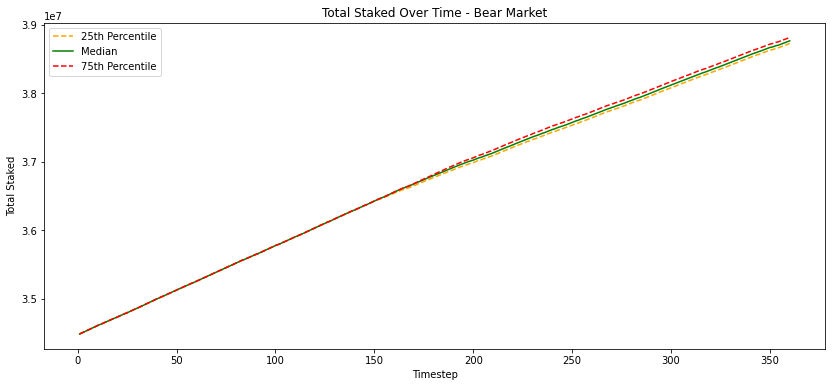

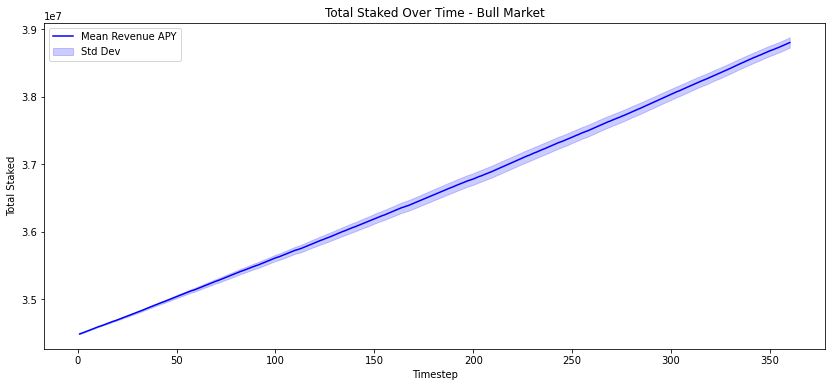

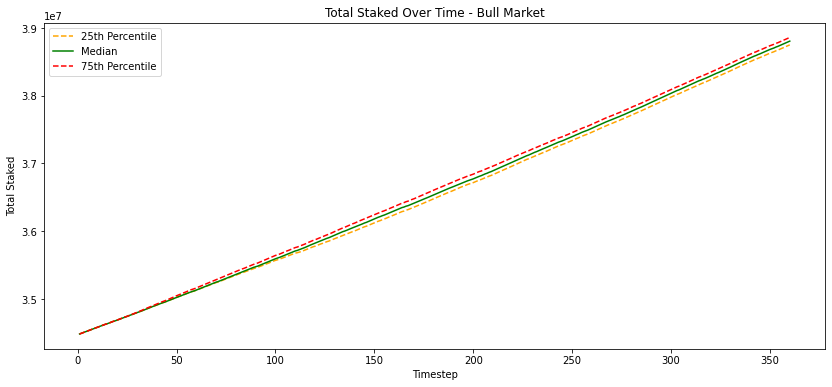

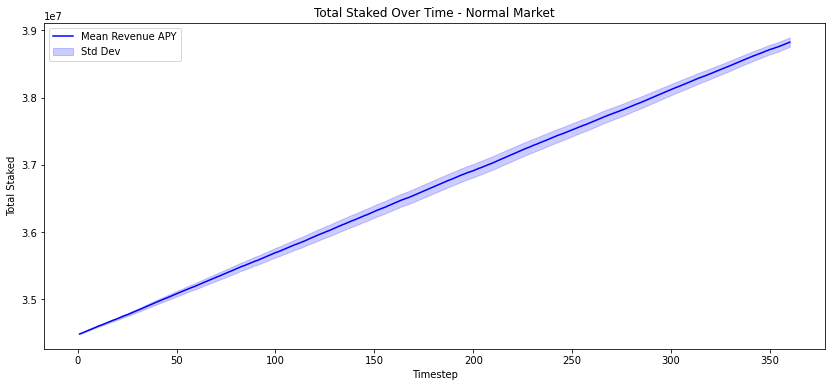

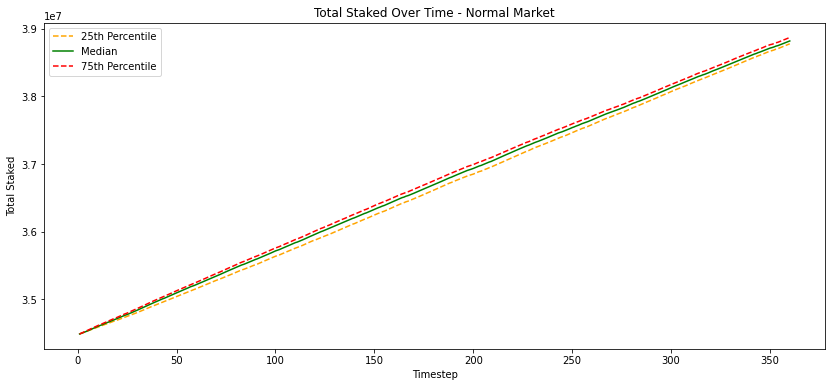

In [70]:
plot_total_staked(final_results, title = "Bear Market")
plot_total_staked(final_results_convex, title = "Bull Market")
plot_total_staked(final_results_none, title = "Normal Market")